# Eye State Detection Train Test Split

In [0]:
%matplotlib inline

import numpy as np
import pandas as pd

random_seed = 123
np.random.seed(random_seed)

import warnings
warnings.filterwarnings('ignore')

In [0]:
train = pd.read_csv("https://raw.githubusercontent.com/sdgroeve/Machine_Learning_course_UGent_D012554/master/kaggle/EEG_Eye_State.csv")

X = train.sample(frac=1).copy()
y = X.pop("eyeDetection")

### Preprocess features

First we remove the outliers and fit a StandardScaler on the dataset. 

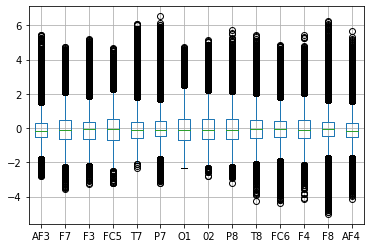

In [3]:
from scipy import stats
from sklearn import preprocessing

nonoutliers = (np.abs(stats.zscore(X)) < 3).all(axis=1)
X_clean = X[nonoutliers]
y_clean = y[nonoutliers]

scaler = preprocessing.StandardScaler()
scaler.fit(X_clean)
X_norm = pd.DataFrame(scaler.transform(X_clean),columns=X_clean.columns)

X_norm.boxplot()

### PCA

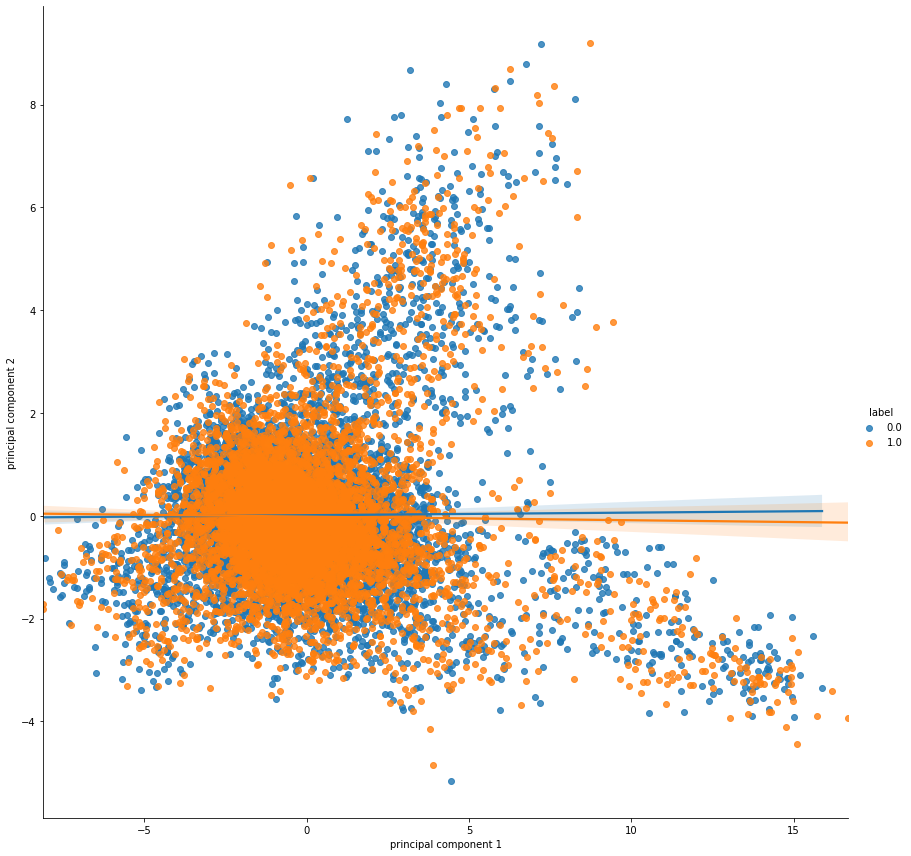

In [4]:
from sklearn.decomposition import PCA
import seaborn as sns

pca = PCA(n_components=2)
principalComponents = pca.fit_transform(X_norm)
principalDf = pd.DataFrame(data = principalComponents
             , columns = ['principal component 1', 'principal component 2'])
principalDf["label"] = y_clean
sns.lmplot(x="principal component 1",y="principal component 2",hue="label",height=12,data=principalDf)

### t-SNE

In [5]:
import numpy as np
from sklearn.manifold import TSNE
X_embedded = TSNE(n_components=2,perplexity=50).fit_transform(X_norm)
X_embedded

array([[-13.116241,  81.23392 ],
       [ 16.878334, -10.307433],
       [-59.402683, -33.759834],
       ...,
       [-62.577835,  45.391808],
       [-43.247047, -27.327175],
       [ 41.46603 , -52.490993]], dtype=float32)

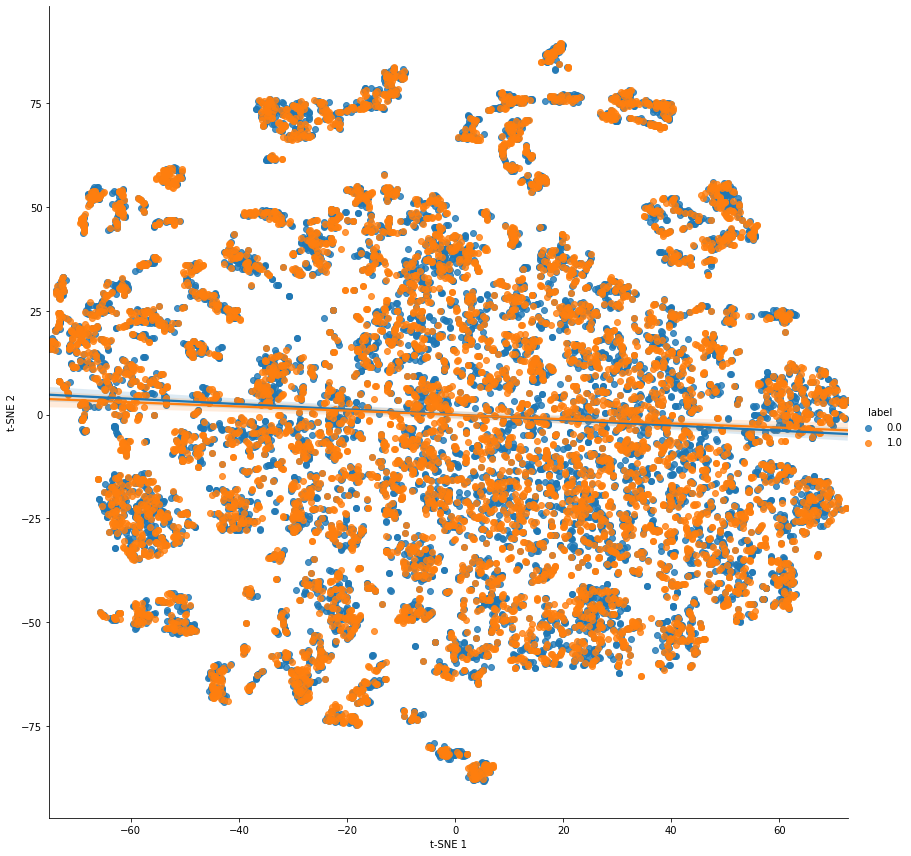

In [6]:
principalDf = pd.DataFrame(data = X_embedded
             , columns = ['t-SNE 1', 't-SNE 2'])
principalDf["label"] = y_clean
sns.lmplot(x="t-SNE 1",y="t-SNE 2",hue="label",data=principalDf,height=12)

#### !The regression lines indicate the labels are distributed randomly.

### k-means on t-SNE projection

In [0]:
from sklearn.cluster import KMeans
kmeans = KMeans(n_clusters=30, random_state=0).fit(principalDf[['t-SNE 1', 't-SNE 2']])
principalDf["kmeans"] = kmeans.labels_

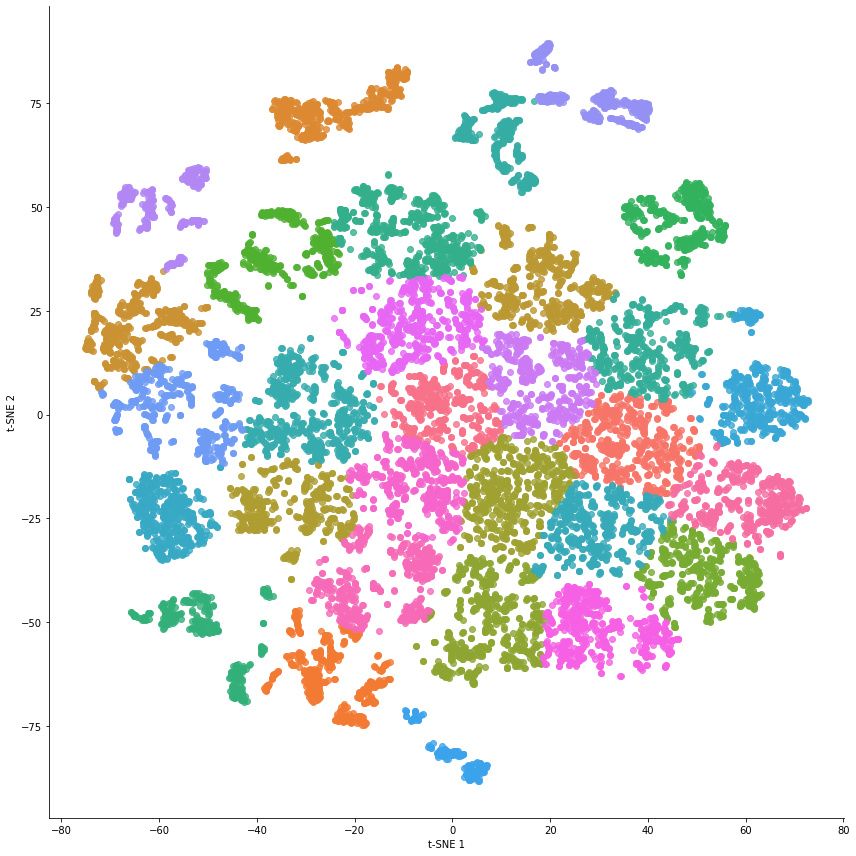

In [8]:
sns.lmplot(x="t-SNE 1",y="t-SNE 2",hue="kmeans",fit_reg=False,legend=False,data=principalDf,height=12)